In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
import glob

In [2]:
warnings.filterwarnings('ignore')

In [3]:
split_files = glob.glob('split_*.csv')
df_list = [pd.read_csv(file) for file in split_files]
df = pd.concat(df_list, ignore_index=True)

In [4]:
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


<span style="color: orange;">
1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).<br>
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.<br>
3. amount - amount of the transaction in local currency.<br>
4. nameOrig - customer who started the transaction<br>
5. oldbalanceOrg - initial balance before the transaction<br>
6. newbalanceOrig - new balance after the transaction<br>
7. nameDest - customer who is the recipient of the transaction<br>
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).<br>
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).<br>
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.<br>
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
</span>

In [5]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [6]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e

In [7]:
print("\nUnique values in 'type' column:")
print(df['type'].unique())

print("\nCount of unique values in 'isFraud' column:")
print(df['isFraud'].value_counts())


Unique values in 'type' column:
['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']

Count of unique values in 'isFraud' column:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


<span style="color: orange;">It can be clearly seen that target variable "isFraud" is highly imbalanced.<br>This significant imbalance indicates that if a model simply predicts every transaction as non-fraudulent, it would achieve a high accuracy but fail to detect any fraudulent transactions.<br>
Models trained on this dataset may struggle to learn the characteristics of fraudulent transactions due to their scarcity. Accuracy will be misleading; hence, alternative metrics like precision, recall, F1-score, and ROC-AUC should be prioritized to evaluate model performance effectively.</span>

<span style="color: orange;">To deal with this imabalance downsampling of the majority class and SMOTE is done.</span>

In [8]:
missing_values = df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


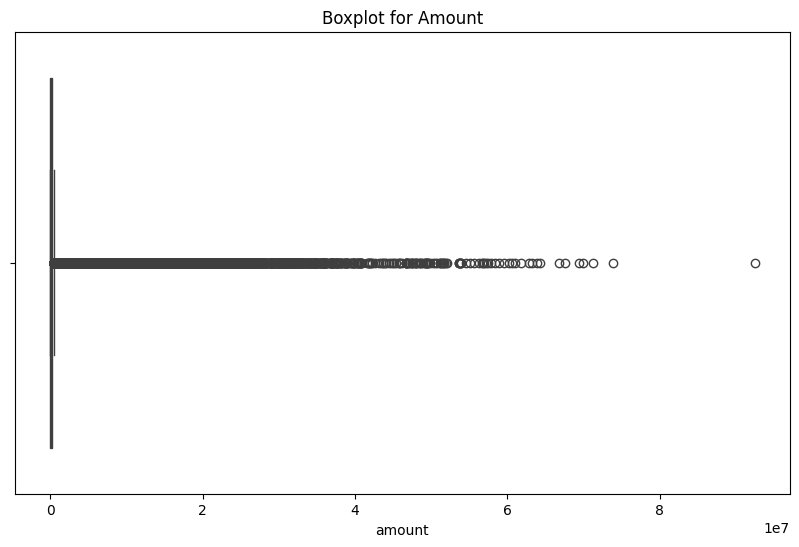

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['amount'])
plt.title('Boxplot for Amount')
plt.show()

Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [10]:
outliers = df[(df['amount'] < lower_bound) | (df['amount'] > upper_bound)]
print("\nNumber of outliers in Amount:", outliers.shape[0])


Number of outliers in Amount: 338078


In [11]:
df['balance_change_Org'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_change_Dest'] = df['oldbalanceDest'] - df['newbalanceDest'].fillna(0)

print("First 5 rows with new features:\n", df[['balance_change_Org', 'balance_change_Dest']].head())

First 5 rows with new features:
    balance_change_Org  balance_change_Dest
0             9839.64                  0.0
1             1864.28                  0.0
2              181.00                  0.0
3              181.00              21182.0
4            11668.14                  0.0


<span style="color: orange;">Downsampling the majority class to handle imbalance</span>

In [12]:
df_majority = df[df.isFraud == 0]
df_minority = df[df.isFraud == 1]

df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [13]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [14]:
scaler = StandardScaler()

numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'balance_change_Org', 'balance_change_Dest']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [15]:
print("\nFinal Preprocessed Dataset Info:")
print(df.info())


Final Preprocessed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   step                 int64  
 1   amount               float64
 2   nameOrig             object 
 3   oldbalanceOrg        float64
 4   newbalanceOrig       float64
 5   nameDest             object 
 6   oldbalanceDest       float64
 7   newbalanceDest       float64
 8   isFraud              int64  
 9   isFlaggedFraud       int64  
 10  balance_change_Org   float64
 11  balance_change_Dest  float64
 12  type_CASH_OUT        bool   
 13  type_DEBIT           bool   
 14  type_PAYMENT         bool   
 15  type_TRANSFER        bool   
dtypes: bool(4), float64(7), int64(3), object(2)
memory usage: 606.8+ MB
None


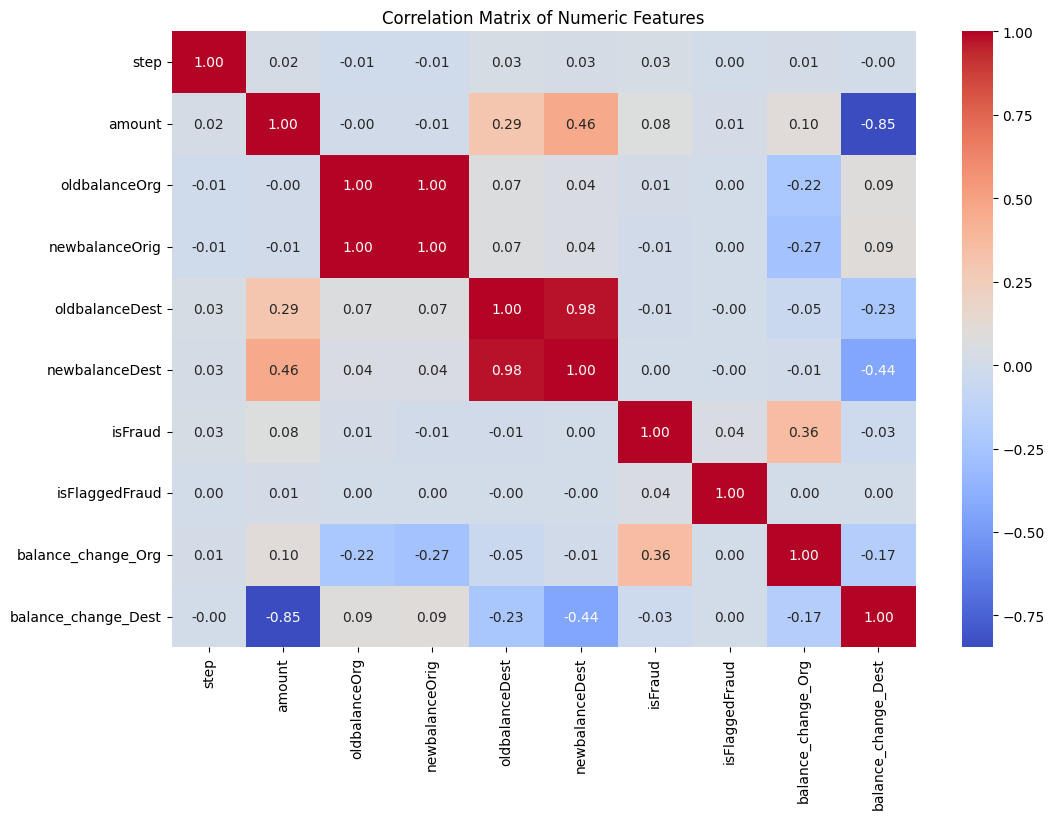

In [16]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [17]:
X = df.select_dtypes(include=['float64', 'int64']).dropna()

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

               Feature          VIF
0                 step     1.003137
1               amount     3.771634
2        oldbalanceOrg          inf
3       newbalanceOrig          inf
4       oldbalanceDest  3342.999114
5       newbalanceDest  3904.007746
6              isFraud     1.186855
7       isFlaggedFraud     1.002562
8   balance_change_Org          inf
9  balance_change_Dest   177.345406


<span style="color: orange;">After removing 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', and 'newbalanceDest', multicollinearity is reduced.<br>All remaining features now have acceptable VIF values, indicating no severe multicollinearity.</span>

In [18]:
X_reduced = X.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])

vif_data_reduced = pd.DataFrame()
vif_data_reduced["Feature"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data_reduced)

               Feature       VIF
0                 step  1.002609
1               amount  3.609737
2              isFraud  1.180242
3       isFlaggedFraud  1.002536
4   balance_change_Org  1.204580
5  balance_change_Dest  3.675092


In [19]:
X = df_balanced[['step', 'amount', 'isFlaggedFraud', 'balance_change_Org', 'balance_change_Dest']]
y = df_balanced['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<span style="color: orange;">Handling class imbalance using SMOTE</span>

In [20]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

<span style="color: orange;">Implementing multiple algorithms and comparing their metrics.</span>

In [21]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [22]:
results = {}

In [23]:
for name, model in models.items():
    
    model.fit(X_train_resampled, y_train_resampled)
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    results[name] = {
        "Confusion Matrix": cm,
        "Classification Report": report,
        "ROC AUC Score": roc_auc
    }

In [24]:
for model_name, metrics in results.items():
    print(f"\n--- {model_name} ---")
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("\nClassification Report:\n", metrics["Classification Report"])
    print(f"\nROC AUC Score: {metrics['ROC AUC Score']:.4f}")



--- Logistic Regression ---
Confusion Matrix:
 [[1592   57]
 [ 189 1448]]

Classification Report:
 {'0': {'precision': 0.8938798427849522, 'recall': 0.9654335961188599, 'f1-score': 0.9282798833819242, 'support': 1649.0}, '1': {'precision': 0.9621262458471761, 'recall': 0.8845448992058644, 'f1-score': 0.9217059197963081, 'support': 1637.0}, 'accuracy': 0.9251369446135118, 'macro avg': {'precision': 0.9280030443160642, 'recall': 0.9249892476623622, 'f1-score': 0.9249929015891162, 'support': 3286.0}, 'weighted avg': {'precision': 0.9278784312855184, 'recall': 0.9251369446135118, 'f1-score': 0.9250049051744825, 'support': 3286.0}}

ROC AUC Score: 0.9738

--- Random Forest ---
Confusion Matrix:
 [[1575   74]
 [  74 1563]]

Classification Report:
 {'0': {'precision': 0.9551243177683445, 'recall': 0.9551243177683445, 'f1-score': 0.9551243177683445, 'support': 1649.0}, '1': {'precision': 0.9547953573610263, 'recall': 0.9547953573610263, 'f1-score': 0.9547953573610263, 'support': 1637.0}, 'acc

<span style="color: orange;">XGBoost is the best choice for this dataset due to its high ROC AUC and balanced performance across precision and recall.</span>

In [25]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=5, random_state=42, scoring='f1')
random_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='f1')

In [26]:
y_pred_proba = random_search.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.57).astype(int) 

In [27]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, random_search.predict_proba(X_test)[:, 1]))

Confusion Matrix:
[[1596   53]
 [  79 1558]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1649
           1       0.97      0.95      0.96      1637

    accuracy                           0.96      3286
   macro avg       0.96      0.96      0.96      3286
weighted avg       0.96      0.96      0.96      3286


ROC AUC Score:
0.9936265773336647
